In [1]:
pip install raidionicsval@git+https://github.com/dbouget/validation_metrics_computation.git@master#raidionicsval

  Cloning https://github.com/dbouget/validation_metrics_computation.git (to revision master) to /home/tmp/pip-install-9new7mzu/raidionicsval_18df6bf0244c4232aa9ebfe687db53f1
  Running command git clone --filter=blob:none --quiet https://github.com/dbouget/validation_metrics_computation.git /home/tmp/pip-install-9new7mzu/raidionicsval_18df6bf0244c4232aa9ebfe687db53f1
  Resolved https://github.com/dbouget/validation_metrics_computation.git to commit 0ee14884dbdcc7b38b3f94ce02848fbf1241fc44
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Download the test data
import os
import requests
import zipfile
resources_url = 'https://github.com/raidionics/Raidionics-models/releases/download/v1.3.0-rc/Samples-RaidionicsValLib_UnitTest1-v1.1.zip'
test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)
print("Test directory: {}".format(test_dir))
archive_dl_dest = os.path.join(test_dir, 'resources.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(resources_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
            
with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
    zip_ref.extractall(test_dir)

print("Raw dataset located in: {}".format(os.path.join(test_dir, "Test1", "Inputs")))
print("Model predictions located in: {}".format(os.path.join(test_dir, "Test1", "Predictions")))

Test directory: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir
Raw dataset located in: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir/Test1/Inputs
Model predictions located in: /home/dbouget/Code/Private/validation_metrics_computation/notebooks/unit_tests_results_dir/Test1/Predictions


In [5]:
import configparser
import shutil
from raidionicsval.compute import compute

output_folder = os.path.join(test_dir, 'Test1', 'Results')
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder)

val_config = configparser.ConfigParser()
val_config.add_section('Default')
val_config.set('Default', 'task', 'validation')
val_config.set('Default', 'data_root', os.path.join(test_dir, "Test1", 'Inputs'))
val_config.set('Default', 'number_processes', "1")
val_config.add_section('Validation')
val_config.set('Validation', 'input_folder', os.path.join(test_dir, "Test1", "Predictions"))
val_config.set('Validation', 'output_folder', os.path.join(test_dir, output_folder))
val_config.set('Validation', 'gt_files_suffix', 'label_tumor.nii.gz')
val_config.set('Validation', 'prediction_files_suffix', 'pred_tumor.nii.gz')
val_config.set('Validation', 'use_index_naming_convention', 'false')
val_config.set('Validation', 'nb_folds', '1')
val_config.set('Validation', 'split_way', 'three-way')
val_config.set('Validation', 'detection_overlap_thresholds', '0.')
val_config.set('Validation', 'metrics_space', 'pixelwise, patientwise, objectwise')
val_config.set('Validation', 'class_names', 'tumor')
val_config.set('Validation', 'extra_metrics', '')
val_config.set('Validation', 'tiny_objects_removal_threshold', '25')
val_config.set('Validation', 'true_positive_volume_thresholds', '0.1')
val_config.set('Validation', 'use_brats_data', 'false')
config_filename = os.path.join(test_dir, 'config.ini')
with open(config_filename, 'w') as outfile:
    val_config.write(outfile)

print("Running 1-fold cross-validation unit test.")
compute(config_filename)

# Modifying the configuration file for running the study task
studies_output_folder = os.path.join(output_folder, "Studies")
os.makedirs(studies_output_folder)
val_config.set('Default', 'task', 'study')
val_config.add_section('Studies')
val_config.set('Studies', 'input_folder', output_folder)
val_config.set('Studies', 'output_folder', studies_output_folder)
val_config.set('Studies', 'task', "segmentation")
val_config.set('Studies', 'class_names', "tumor")
val_config.set('Studies', 'extra_parameters_filename', os.path.join(test_dir, 'Patient1',
                                                                    'Predictions',
                                                                    'external_patient_parameters.csv'))
val_config.set('Studies', 'selections_dense', "PiW Dice,GT volume (ml),4,TP")
config_filename = os.path.join(output_folder, 'config.ini')
with open(config_filename, 'w') as outfile:
    val_config.write(outfile)
    
print("Running study analysis task.")
compute(config_filename)

Running 1-fold cross-validation unit test.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:21<00:00, 32.11s/it]


Running study analysis task.
Computed confidence intervals for: _overall_tumor

[[0.87787323]
 [0.93272961]]
[[0.87734262]
 [0.93336452]]


/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric

Computed confidence intervals for: _overall_tumor_Positive

[[0.8796181 ]
 [0.93335437]]
[[0.87880513]
 [0.93365252]]


/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric

Computed confidence intervals for: _overall_tumor_TP

[[0.87750643]
 [0.93351598]]
[[0.87912553]
 [0.93328354]]


/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/numpy/_core/fromnumeric

Computing and plotting PiW Dice over GT volume (ml) with the following cut-off values [[4.0]].

Skipping analysis for GT volume (ml) <=4.0. Collected pd.DataFrame is empty.

No results for the following combination: GT volume (ml)<=4.0. Skipping...
No results for the following combination: GT volume (ml)<=4.0. Skipping...
No results for the following combination: GT volume (ml)<=4.0. Skipping...


/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/pandas/io/formats/style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/pandas/io/formats/style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax
/home/dbouget/Code/Private/validation_metrics_computation/venv-test/lib/python3.10/site-packages/pandas/io/f

<Figure size 640x480 with 0 Axes>

In [6]:
# Visualize the correlation between all computed metrics for the true positive patients
from IPython.display import HTML, display

correlation_matrix_path = os.path.join(studies_output_folder, 'correlation_matrix_tumor_TP.html')
with open(correlation_matrix_path, 'r') as file:
    html_content = file.read()

display(HTML(html_content))

,PiW Dice,PiW Recall,PiW Precision,PiW F1,GT volume (ml),True Positive,Detection volume (ml),OW Global Recall,OW Global Precision,OW Global F1,OW Dice,OW Dice (std),OW Recall,OW Recall (std),OW Precision,OW Precision (std),OW F1,OW F1 (std),#GT,#Det
PiW Dice,1.000000,0.565088,0.738011,1.000000,0.521950,nan,0.534655,-0.152426,0.594020,0.082306,0.973802,-0.564946,0.485443,-0.227705,0.721704,-0.590330,0.973802,-0.564946,-0.068463,-0.492064
PiW Recall,0.565088,1.000000,-0.138846,0.565088,0.030274,nan,0.056051,-0.116556,-0.234371,-0.203203,0.405560,0.239061,0.987428,0.155922,-0.161137,0.236200,0.405560,0.239061,0.220897,0.229426
PiW Precision,0.738011,-0.138846,1.000000,0.738011,0.617846,nan,0.612133,-0.077249,0.889692,0.269220,0.833594,-0.859771,-0.222360,-0.396752,0.995730,-0.886935,0.833594,-0.859771,-0.267878,-0.766730
PiW F1,1.000000,0.565088,0.738011,1.000000,0.521950,nan,0.534655,-0.152426,0.594020,0.082306,0.973802,-0.564946,0.485443,-0.227705,0.721704,-0.590330,0.973802,-0.564946,-0.068463,-0.492064
GT volume (ml),0.521950,0.030274,0.617846,0.521950,1.000000,nan,0.999191,-0.141181,0.325466,-0.010624,0.542560,-0.382492,0.038137,-0.423070,0.577852,-0.338273,0.542560,-0.382492,-0.139099,-0.428879
True Positive,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Detection volume (ml),0.534655,0.056051,0.612133,0.534655,0.999191,nan,1.000000,-0.167373,0.316037,-0.039576,0.551366,-0.374807,0.065042,-0.424703,0.571394,-0.329163,0.551366,-0.374807,-0.114836,-0.423869
OW Global Recall,-0.152426,-0.116556,-0.077249,-0.152426,-0.141181,nan,-0.167373,1.000000,-0.111111,0.923291,-0.165465,0.135049,-0.121206,0.162709,-0.085441,0.116392,-0.165465,0.135049,-0.804030,0.156174
OW Global Precision,0.594020,-0.234371,0.889692,0.594020,0.325466,nan,0.316037,-0.111111,1.000000,0.279135,0.746217,-0.976992,-0.319235,-0.489379,0.927104,-0.999060,0.746217,-0.976992,-0.301511,-0.884985
OW Global F1,0.082306,-0.203203,0.269220,0.082306,-0.010624,nan,-0.039576,0.923291,0.279135,1.000000,0.128530,-0.247112,-0.240496,-0.031927,0.275764,-0.273669,0.128530,-0.247112,-0.893414,-0.191141


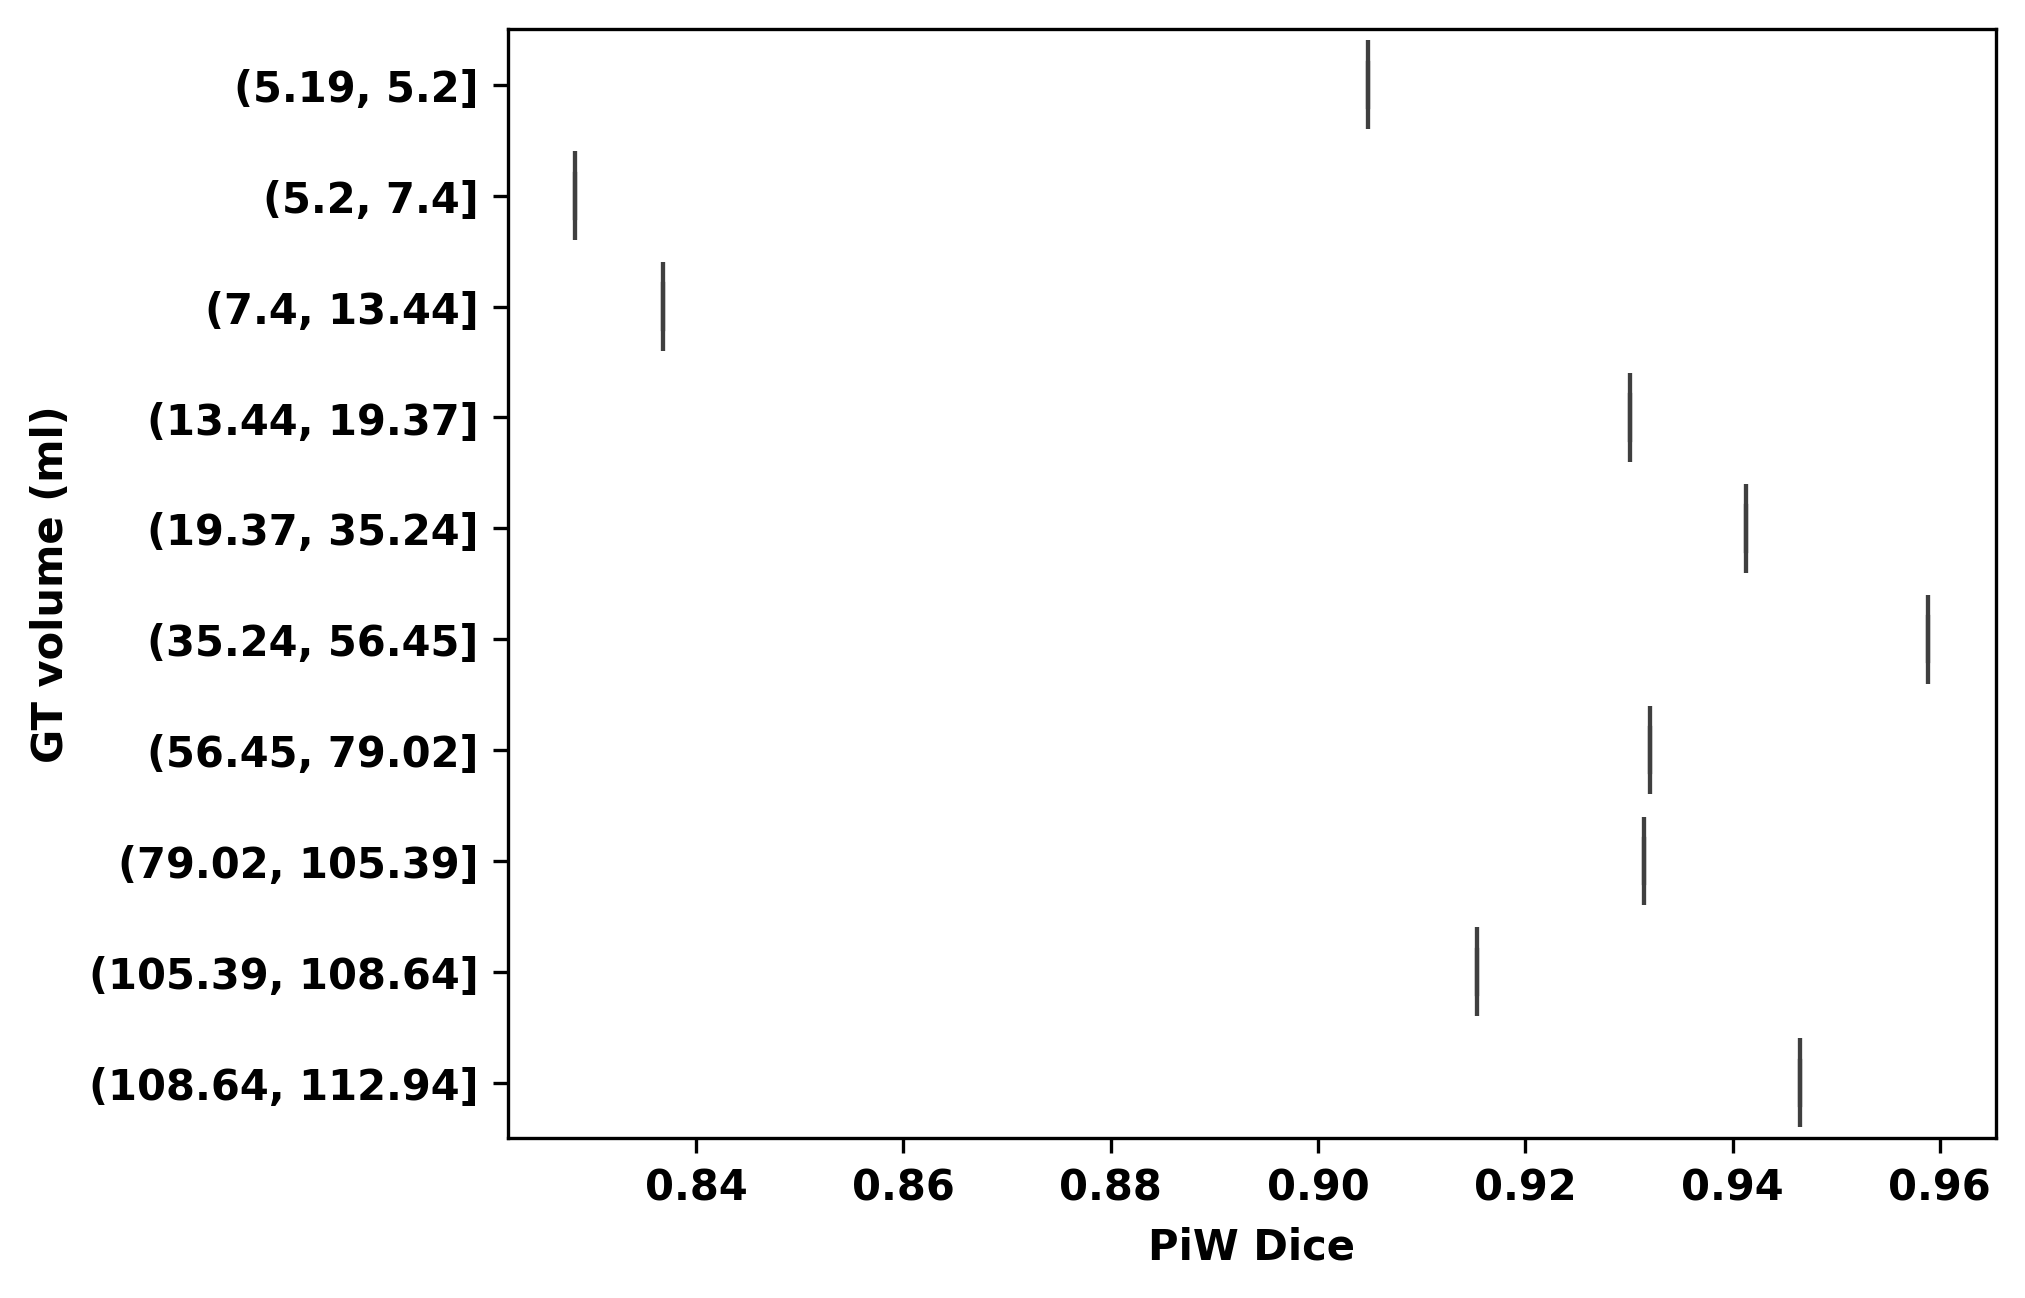

In [11]:
# Visualize the Pixel-wise Dice versus volume (ml) distribution as boxplots for the tumor class
from IPython.display import Image

boxplot_filename = os.path.join(studies_output_folder, 'PiWDice_GTvolume(ml)-Wise', 'boxplots', 'boxplot_PiWDice_over_GTvolume(ml)_equal_bins_overall__tumor_TP.png')
display(Image(filename=boxplot_filename))